# **Agricultural drought in central South America**

- use 1980-2010 to calibrate - this period exists in ERA5, CPC, MSWEP
- under the [standard drought classification](https://droughtmonitor.unl.edu/About/AbouttheData/DroughtClassification.aspx) we're interested in moderate droughts (threshold 0.8). Classify as a drought month if below -0.8, drought ends when > -0.8 (NOT over zero) for two or more months.
- see Reddy & Ganguli, application of copulas for derivation of drought severity–duration–frequency curves


Still to check/do:
- for SPI3, should drought severity be computed by summing all monthly values, or three-monthly?
- filtering of arid regions needed (exclude >0.25% zero values; prcptot/pet <= 0.05)

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

from xclim.indices.stats import fit
from xclim.indices.run_length import rle
from xclim.indices.run_length import _cumsum_reset_on_zero as run_cumsum


import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

import warnings
warnings.filterwarnings("ignore", message = "overflow encountered in exp.+")                           # warning about change to Cartopy plotting defaults

## **Exploratory**

### **Data pre-processing**

#### **Trim ERA5 to S America land surface, update with January data**

In [122]:
# trim data & save as monthly
lsm = xr.open_dataset("../../Data/era5/era5_lsm_025.nc").squeeze(drop = True).lsm.sel(latitude = slice(-10,-50), longitude = slice(280,320)).rename(longitude = "lon", latitude = "lat")

pr_m = decode_times(xr.open_dataset("data/era5_tp_-80--40E_-50--10N_su.nc", decode_times = False)).tp
pr_jan = convert_units_to(xr.open_dataset("data/era5_tp_-80--40E_-50--10E_january-hourly.nc").tp, "mm").rename(latitude = "lat", longitude = "lon")
pr_jan = pr_jan.resample(time = "D").sum().resample(time = "MS").mean()
pr_jan["lon"] = pr_jan.lon + 360
pr = xr.concat([pr_m, pr_jan], "time").rename("precip").where(lsm >= 0.5)
pr.to_netcdf("data/era5_precip_monthly.nc")

In [122]:
# PET also used to compute SPEI in exploratory analysis - but not updated with latest data, since using SPI instead
# decode_times(xr.open_dataset("data/era5_evap_-80--40E_-50--10N_su.nc", decode_times = False)).evap.rename("pet").where(lsm >= 0.5).to_netcdf("data/era5_pet_monthly.nc")

#### **CPC monthly files & PET**

In [2]:
from xclim.indices import potential_evapotranspiration

# trim precip & aggregate to monthly
xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).precip.resample(time = "MS").mean().to_netcdf("data/cpc_precip_monthly.nc")

# compute mean temps, save for later plotting
tmin = xr.open_mfdataset("../../Data/cpc/tmin.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).tmin
tmax = xr.open_mfdataset("../../Data/cpc/tmax.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).tmax
tas = (tmax + tmin) / 2
tas.resample(time = "MS").mean().rename("tas").to_netcdf("data/cpc_tas_monthly.nc")

# compute PET using Hargreaves - McGuinness-Bordne has an issue in Dec/Jan
pet = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "HG85").rename("pet").resample(time = "MS").mean(), "mm/day")
pet.to_netcdf("data/cpc_pet_monthly.nc")

In [291]:
xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).precip.resample(time = "MS").mean().to_netcdf("data/cpc_precip_monthly.nc")

#### **Flatten data for processing in R**

In [59]:
# flatten data for processing in R
for ens in ["era5", "cpc"]:

    # precipitation
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip
    pr = pr.where(np.isnan(pr).sum("time") < 100)
    pr.stack(xy = ["lat", "lon"]).to_pandas().to_csv("data/"+ens+"_pr_monthly.csv")
    
    # effective precipitation
    pet = xr.open_dataset("data/"+ens+"_pet_monthly.nc").pet
    eff_pr = (pr - pet).where(np.isnan(pr).sum("time") < 100)
    eff_pr.stack(xy = ["lat", "lon"]).to_pandas().to_csv("data/"+ens+"_eff-pr_monthly.csv")


### **Compute drought indices**

---
#### **SPI**

In [124]:
for ens in ["era5", "cpc"]:
    
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip
    pr_n = pr.rolling(time = 3, center = False).mean(keep_attrs = False)
    pr_n = pr_n.where(np.isnan(pr_n).sum("time") < 100)                          # skip any cells with high proportion of missing data

    spi_monthly = []
    # fit each calendar month in turn
    for i in range(12):
        
        # select current calendar month
        pr_m = pr_n.sel(time = pr_n.time.dt.month == i+1)
        
        # estimate parameters over calibration period
        pr_cal = pr_m.sel(time = slice("1980", "2010")).copy()
        pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")
        
        # normalise all values using fitted parameters
        spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
        
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spi_finite = xr.concat([spi_m.where(~np.isinf(spi_m)), 
                                xr.ones_like(spi_m).where(spi_m == np.inf) * spi_m.where(spi_m < np.inf).max("time"),
                                xr.ones_like(spi_m).where(spi_m == -np.inf) * spi_m.where(spi_m > -np.inf).min("time")], "new").sum("new").copy()
        
        # append to list of monthly SPI for concatenation
        spi_monthly.append(spi_finite)
        
    # concatenate monthly fitted values, reorder & relabel
    spi = xr.concat(spi_monthly, "time").sortby("time").rename("spi").assign_attrs(long_name = "SPI_3", notes = "Calibrated against 1980-2010")
    spi = spi.where(~np.isnan(pr_n)).dropna("time", "all")
    
    # save to netcdf
    spi.to_netcdf("data/"+ens+"_spi3_monthly.nc")

---
#### **SPEI**

This method replicates the fitting approach using in R (originally used to compute the SPI/SPEI).  
The PWM-estimated parameters fitted by lmoments3/xclim are based on a different parametrisation to that used in scipy: the CDF used here is taken from Hosking (1997):
\begin{align}
F(x) = \left(1+e^{-y}\right)^{-1}, &&\text{with}&& y = \left\lbrace 
    \begin{matrix} 
        -\log\left(1- \frac{\kappa(x-\xi)}{\alpha}\right) \big/ \kappa, && \kappa \neq 0 \\
        \frac{(x-\xi)}{\alpha}, && \kappa = 0
    \end{matrix} \right.
\end{align}

Note that $y$ is not defined for $\frac{\kappa(x-\xi)}{\alpha} >= 1$: where this occurs (indicating precipitation exceeding that possible under the calibration distribution), set $y = -log(0.00001) / k$

Where the CDF is found to be either 0 or 1, the normalisation step fails: the resulting infinite values are replaced with the max/min of the finite values, as appropriate.

In [4]:
# CDF of generalised logistic function used with PWM parametrisation (replicates that used in R)
def hosking_cdf(x, k, loc, scale):
    
    x_scaled = (x-loc) / scale
    
    if k == 0:
        y = x_scaled
    else:
        # if scaled value is greater than 1, replace with 0.99999 (otherwise log is NA):
        # this occurs when observed value falls above range of calibration distribution
        x_scaled = k*x_scaled
        x_scaled[x_scaled >= 1] = 0.99999
        y = -np.log(1 - x_scaled) / k
        
    Fx = 1/(1+np.exp(-y))
            
    return Fx

In [5]:
for ens in ["era5", "cpc"]:
    
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip
    pet = xr.open_dataset("data/"+ens+"_pet_monthly.nc").pet
    eff_pr = (pr - pet).where(np.isnan(pr).sum("time") < 100)              # skip any cells with high proportion of missing data
    
    epr_n = eff_pr.rolling(time = 3, center = False).mean(keep_attrs = False)

    spei_monthly = []
    for i in range(12):
        
        # select current calendar month
        epr_m = epr_n.sel(time = epr_n.time.dt.month == i+1)
        
        # estimate parameters over calibration period
        epr_cal = epr_m.sel(time = slice("1980", "2010")).copy()
        
        # fit parameters for whole map (has to be done manually due to bug in xclim)
        pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())), epr_cal,
                              input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])
        
        # running without dry-month normalisation for now - check if needed for this dataset
        spei_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(hosking_cdf(pr, *dparams)), epr_m, pars, 
                                input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = epr_m.time)
        
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spei_finite = xr.concat([spei_m.where(~np.isinf(spei_m)), 
                                 xr.ones_like(spei_m).where(spei_m == np.inf) * spei_m.where(spei_m < np.inf).max("time"),
                                 xr.ones_like(spei_m).where(spei_m == -np.inf) * spei_m.where(spei_m > -np.inf).min("time")], "new").sum("new").copy()
        
        spei_monthly.append(spei_finite)
        
    spei = xr.concat(spei_monthly, "time").sortby("time").rename("spei").assign_attrs(long_name = "SPEI_3", notes = "Calibrated against 1980-2010")
    spei = spei.where(~np.isnan(epr_n)).dropna("time", "all")
    
    # save to netcdf
    spei.to_netcdf("data/"+ens+"_spei3_monthly.nc")

/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/249573

---
#### **Drought severity & duration**
Droughts classified if moderate or worse per the US drought monitor index - begins in the month when the SPI falls below -0.8, ends when it returns above this level for at least 2 consecutive months

In [31]:
from xclim.indices.run_length import _cumsum_reset_on_zero as run_cumsum

for ens in ["era5", "cpc"]:
    for varnm in ["spi3", "spei3"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+".nc")[re.sub("3", "", varnm)]
        
        # identify drought months (1 if in drought, 0 otherwise)
        idx_lo = xr.ones_like(da).where(rle(da <= -0.8) > 0)      # indicator for start of drought
        idx_pos = xr.zeros_like(da).where(rle(da > -0.8) > 1)     # indicator for start of non-drought period
        drought_months = xr.concat([idx_lo, idx_pos], "new").max("new").ffill("time").rename("drought_months")
        drought_months.to_netcdf("data/"+ens+"_"+varnm+"-drought-months.nc")

        drought_length = run_cumsum(drought_months.where(drought_months == 1, 0)).where(~np.isnan(da))
        drought_length.rename("drought_duration").assign_attrs(long_name = "Drought duration", units = "months").to_netcdf("data/"+ens+"_"+varnm+"-drought-duration.nc")
        
        drought_severity = run_cumsum(da.where(drought_months == 1, 0)).where(~np.isnan(da))
        drought_severity.rename("drought_severity").assign_attrs(long_name = "Drought severity").to_netcdf("data/"+ens+"_"+varnm+"-drought-severity.nc")
        
        # could also add drought intensity if useful - but this may take some time, as no inbuilt method in xclim

Text(0.5, 1.0, 'Drought severity')

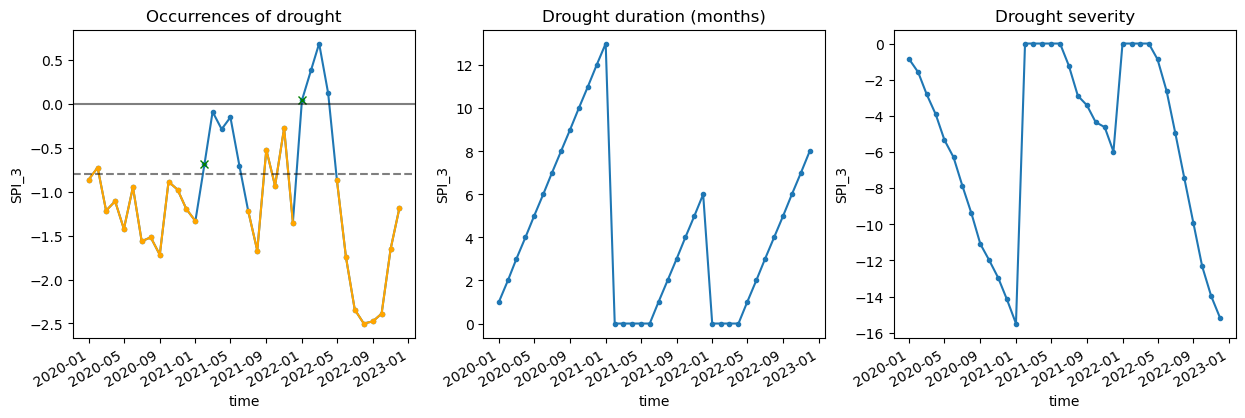

In [17]:
# time series plots for a single cell, to confirm that the calculation works

latlon = get_latlon("Buenos Aires, AR").values()
da = wrap_lon(xr.open_dataset("data/era5_spi3_monthly.nc").spi.rename(lat = "latitude", lon = "longitude").sel(time = slice("2020", None)))

fig, axs = plt.subplots(ncols = 3, dpi = 100, figsize = (15,4))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts = nearest_px(*latlon, da)
ts_lo = xr.ones_like(ts).where(rle(ts <= -0.8) > 0)                    # indicator for start of drought
ts_pos = xr.zeros_like(ts).where(rle(ts > -0.8) > 1)                   # indicator for start of non-drought
dm = xr.concat([ts_lo, ts_pos], "new").max("new").ffill("time")         # indicator for months during drought

ts.plot(ax = axs[0], marker = ".")
ts.where(ts_pos == 0).plot(ax = axs[0], color = "green", marker = "x")
ts.where(dm == 1).plot(ax = axs[0], color = "orange", marker = ".")

[axs[0].axhline(x, color = "k", ls = "--", alpha = 0.5) for x in [-0.8]]
[axs[0].axhline(x, color = "k", alpha = 0.5) for x in [0]]
axs[0].set_title("Occurrences of drought")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

run_cumsum(dm.where(dm == 1, 0)).plot(ax = axs[1], marker = ".")
axs[1].set_title("Drought duration (months)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

run_cumsum(ts.where(dm == 1, 0)).plot(ax = axs[2], marker = ".")
axs[2].set_title("Drought severity")

---
### **Monthly maps of last three years**

#### **Precipitation**

In [15]:
for ens in ["cpc", "era5"]:
    
    da = xr.open_dataset("data/"+ens+"_precip_monthly.nc").sel(time = slice("2020-07", None)).precip
    
    nr = int(np.ceil(len(da.time) / 12))
    fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
    for ax in fig.axes[len(da.time):]: ax.set_axis_off()
    
    for i in range(len(da.time)):
        
        ax = fig.axes[i]
        cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmin = 0, vmax = 25, cmap = 'YlGnBu')
        xr.ones_like(da).where(da == 0).isel(time = i).plot(ax = ax, add_colorbar = False, cmap = "Oranges_r", vmin = 0, vmax = 1)      # overlay zero precip as white regions - reverse cmap to show in orange
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
        ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
    plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Daily precipitation rate (mm/day)", extend = "max")
    plt.suptitle(ens.upper()+" - mean monthly precipitation", fontweight = "bold")

    plt.savefig("fig/"+ens+"_pr_monthly.png"); plt.close()

#### **Temperature**

In [249]:
for ens in ["cpc", "era5"]:
    
    da = xr.open_dataset("data/"+ens+"_tas_monthly.nc").sel(time = slice("2020-07", None)).tas
    
    nr = int(np.ceil(len(da.time) / 12))
    fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
    for ax in fig.axes[len(da.time):]: ax.set_axis_off()
    
    for i in range(len(da.time)):
        
        ax = fig.axes[i]
        cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmax = 30, vmin = -10, cmap = "RdBu_r")
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
        ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
    plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Temperature (degC)", extend = "both")
    plt.suptitle(ens.upper()+" - monthly mean temperatures", fontweight = "bold")

    plt.savefig("fig/"+ens+"_tas_monthly.png"); plt.close()

#### **PET**

In [250]:
for ens in ["cpc", "era5"]:
    
    da = xr.open_dataset("data/"+ens+"_pet_monthly.nc").sel(time = slice("2020-07", None)).pet
    
    nr = int(np.ceil(len(da.time) / 12))
    fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
    for ax in fig.axes[len(da.time):]: ax.set_axis_off()
    
    for i in range(len(da.time)):
        
        ax = fig.axes[i]
        cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmin = 0, vmax = 6, cmap = "viridis")
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
        ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
    plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "PET (mm/day)", extend = "max")
    plt.suptitle(ens.upper()+" - mean monthly PET rate (mm/day)", fontweight = "bold")

    plt.savefig("fig/"+ens+"_pet_monthly.png"); plt.close()

#### **Drought indices**

In [16]:
for ens in ["cpc", "era5"]:
    for varnm in ["spi", "spei"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3_monthly.nc").sel(time = slice("2020-07", None))[varnm]
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmin = -4, vmax = 4, cmap = "BrBG")
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        if varnm == "spi":
            plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "SPI_3", extend = "both")
            plt.suptitle(ens.upper()+" - 3-month standardised precipitation index", fontweight = "bold")
        else:
            plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "SPEI_3", extend = "both")
            plt.suptitle(ens.upper()+" - 3-month standardised precipitation-evapotranspiration index", fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3_monthly.png"); plt.close()

#### **Drought classification**

In [238]:
drought_bins = [-np.inf, -2, -1.55, -1.25, -.75, -.5]

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow'])
cmap.set_over('honeydew')
bounds = np.arange(0.5,6.5,1)

for ens in ["cpc", "era5"]:
    for varnm in ["spi", "spei"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3_monthly.nc").sel(time = slice("2020-07", None))[varnm]
        da = xr.apply_ufunc(np.digitize, da, kwargs={'bins': bins}).where(~np.isnan(da))
        # da = da.where(da < 6)
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, cmap = cmap, norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N))
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
        cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
        
        plt.suptitle(ens.upper()+" - drought classifications using 3-month "+varnm.upper(), fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3-classification_monthly.png"); plt.close()

#### **Drought severity**

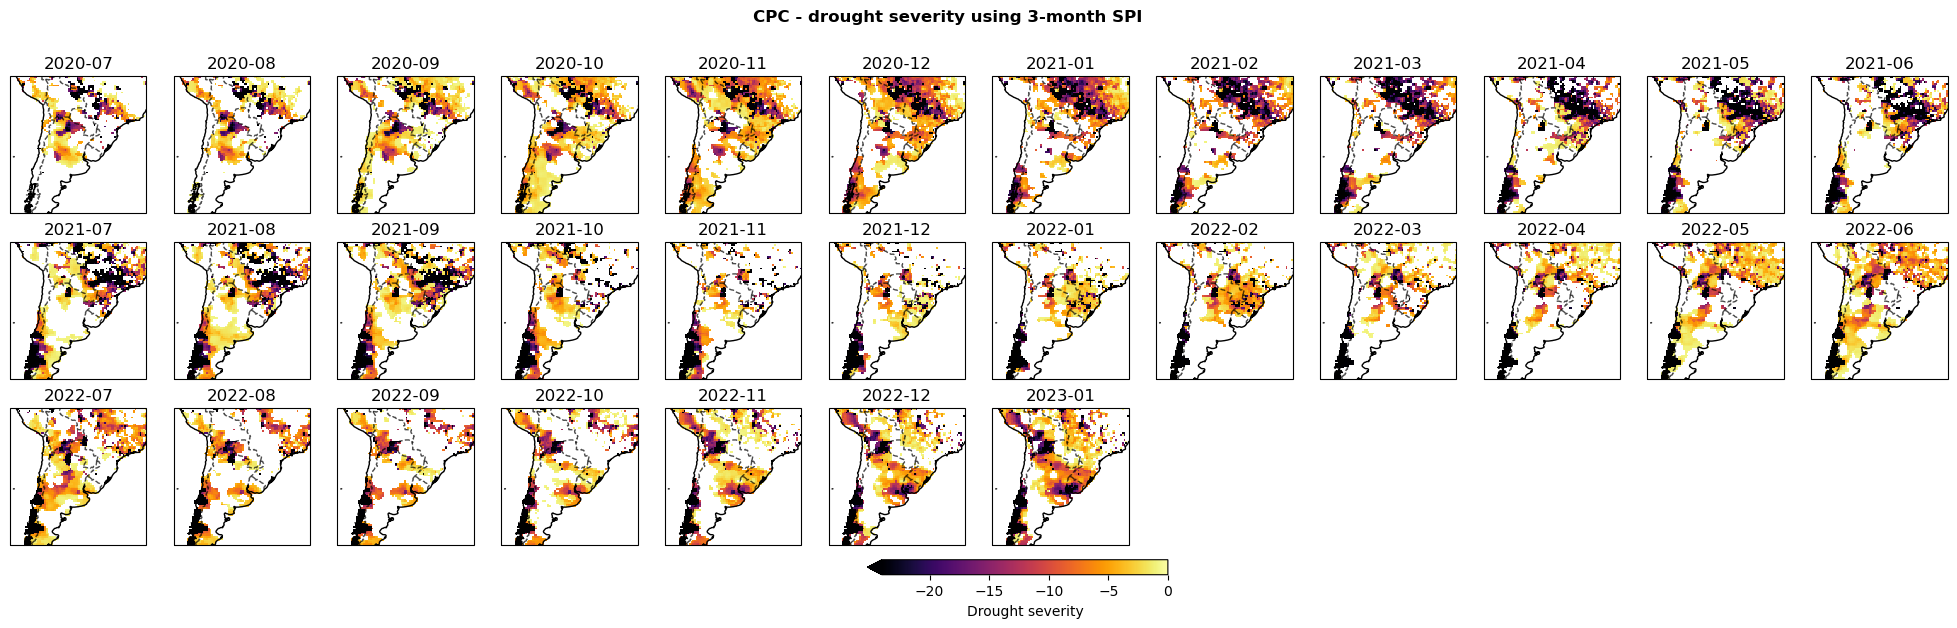

In [19]:
for ens in ["cpc", "era5"][:1]:
    for varnm in ["spi", "spei"][:1]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3-drought-severity.nc").sel(time = slice("2020-07", None)).drought_severity
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).where(da.isel(time = i) < 0).plot(ax = ax, add_colorbar = False, vmax = 0, vmin = -50, cmap = "inferno")
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Drought severity", extend = "min")
        plt.suptitle(ens.upper()+" - drought severity using 3-month "+varnm.upper(), fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3-severity_monthly.png"); plt.close()

#### **Drought duration**

In [239]:
for ens in ["cpc", "era5"]:
    for varnm in ["spi", "spei"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3-drought-duration.nc").sel(time = slice("2020-07", None)).drought_duration
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).where(da.isel(time = i) > 0).plot(ax = ax, add_colorbar = False, vmin = 0, vmax = 12, cmap = "Oranges")
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Drought duration (months)", extend = "max")
        plt.suptitle(ens.upper()+" - drought duration using 3-month "+varnm.upper(), fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3-duration_monthly.png"); plt.close()

---
### **Compare R fitting vs python**

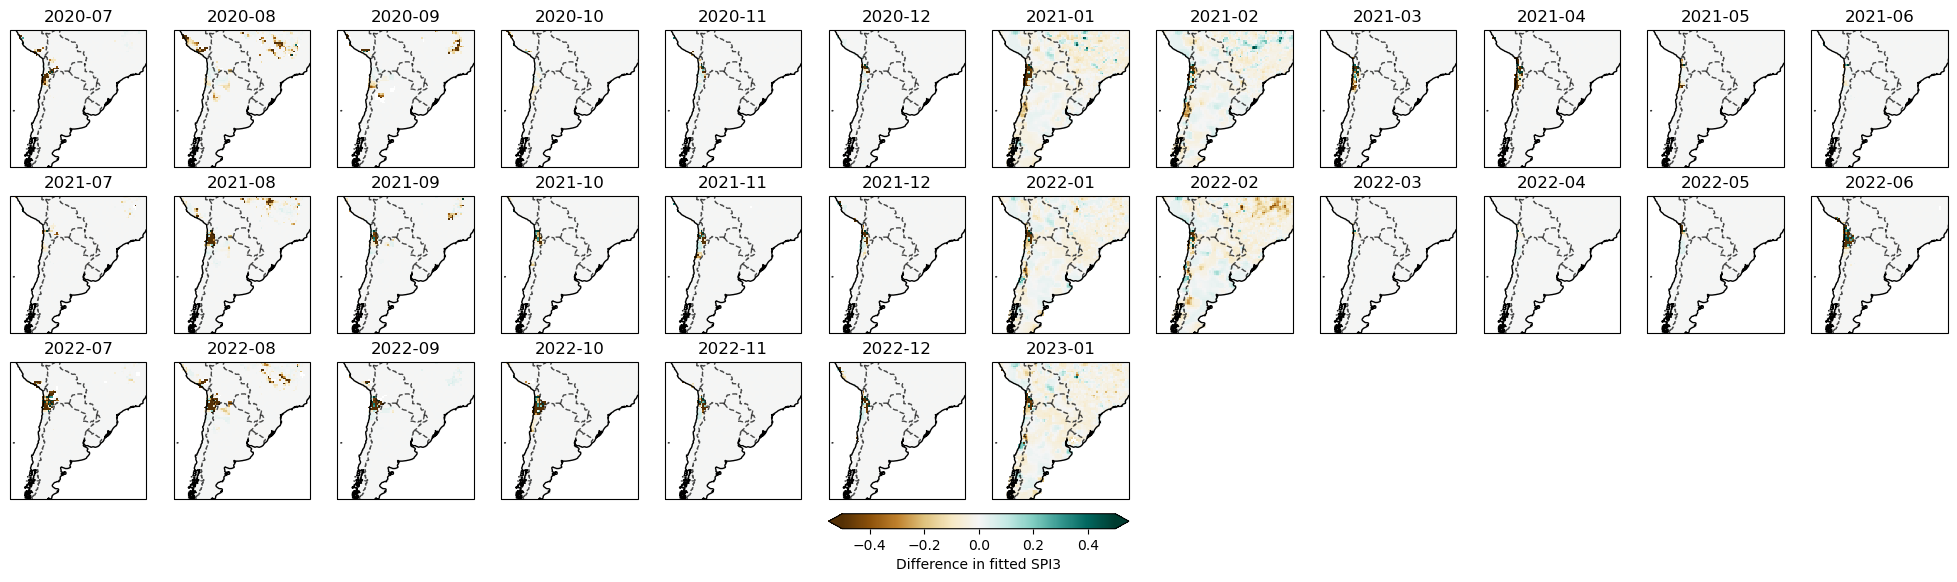

In [110]:
# load values fitted using script above
da_py = xr.open_dataset("data/cpc_spi3_monthly.nc").spi

# load & reshape values fitted using R SPEI package
df = pd.read_csv("data/cpc_spi3_rfitted.csv", index_col = "time").dropna(axis = 0, how = "all")
da_r = xr.DataArray(data = np.array(df).reshape(da_py.transpose("time", ...).shape),
                    dims = {"time" : da_py.time, "lat" : da_py.lat, "lon" : da_py.lon},
                    coords = {"time" : da_py.time, "lat" : da_py.lat, "lon" : da_py.lon})

da = (da_py - da_r).sel(time = slice("2020-07", None))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = int(np.ceil(len(da.time) / 12))
fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
for ax in fig.axes[len(da.time):]: ax.set_axis_off()

for i in range(len(da.time)):
    
    ax = fig.axes[i]
    cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, cmap = "BrBG", vmin = -0.5, vmax = 0.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
    ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Difference in fitted SPI3", extend = "both")

# Atacama desert very different, probably due to presence of large number of zeros in the data. Ditto scattered cells in Brazil.
# slightly larger differences in Jan/Feb (again, this is the dry season, so probably unsurprising)

## **Define spatial region**

### **Build shapefile & extract boundary, points**
Administrative shapefiles downloaded from https://data.humdata.org

In [9]:
# create a single shapefile containing the selected regions

sf_ar = gpd.read_file("sf/AR_adm1").to_crs(cartopy.crs.PlateCarree()).set_index("ADM1_PCODE")
sf_ar = sf_ar[sf_ar.geometry.centroid.y > -36.7]
sf_br = gpd.read_file("sf/BR_adm1").set_crs(cartopy.crs.PlateCarree()).set_index("ADM1_PCODE")
sf_br = sf_br[sf_br.geometry.centroid.y < -24.5]
sf_uy = gpd.read_file("sf/UY_adm0").to_crs(cartopy.crs.PlateCarree()).set_index("ADM0_PCODE")
sf_bo = gpd.read_file("sf/BO_adm1").to_crs(cartopy.crs.PlateCarree()).set_index("ADM1_PCODE")

sf = pd.concat([sf_ar[sf_ar.geometry.centroid.y > -36.7], sf_br[sf_br.geometry.centroid.y < -24.5], sf_uy, sf_bo.loc[["BO06", "BO01"]]])
sf.to_file("sf/provinces")

sf = sf.dissolve().explode(index_parts = False)
sf["geometry"] = sf.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))

In [10]:
gp = xr.open_dataset("../90_data/era5_geopotential-0.25.nc").squeeze(drop = True).z.sel(latitude = slice(-10,-50), longitude = slice(280,320))

# create mask from shapefile
rm = regionmask.mask_3D_geopandas(sf, gp.longitude, gp.latitude).sum("region")

# find areas within Argentina with geopotential < 20000
rm = rm.where(rm).where(gp < 20000).dropna("latitude", "all").dropna("longitude", "all")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CONVERT REGIONMASK BACK INTO TO POLYGON

# define affine transform to correct coordinates
res = 0.25
transform = np.array([res,0,rm.longitude.min().values - res/2,0,-res,rm.latitude.max().values + res/2])

# convert xarray data to polygon, remove any interior holes, select single largest polygon & smooth edges
rm_poly = polygonize(rm, mask = rm == 1, return_type = "geopandas", transform = transform).set_crs(epsg = "4326")
rm_poly["geometry"] = rm_poly.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))
rm_poly = rm_poly[rm_poly.geometry.area == rm_poly.geometry.area.max()]
rm_poly = rm_poly.simplify(0.25)

# save as shapefile
rm_poly.to_file("sf_CSA-drought")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## EXTRACT POINTS FROM POLYGON

rm_px = rm_poly.apply(lambda p: list(p.exterior.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"}))
rm_px["x"] = rm_px.x - 360

# save list of points for upload to climate explorer
rm_px.to_csv("sf_CSA-drought.txt", sep = " ", index = False)

/tmp/ipykernel_40511/3172607388.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rm_poly = rm_poly[rm_poly.geometry.area == rm_poly.geometry.area.max()]


#### **Check shapefile**

In [11]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
px = pd.read_csv("sf_CSA-drought.txt", sep = " ")
gp = xr.open_dataset("../90_data/era5_geopotential-0.25.nc").squeeze(drop = True).z.sel(latitude = slice(-10,-50), longitude = slice(280,320))

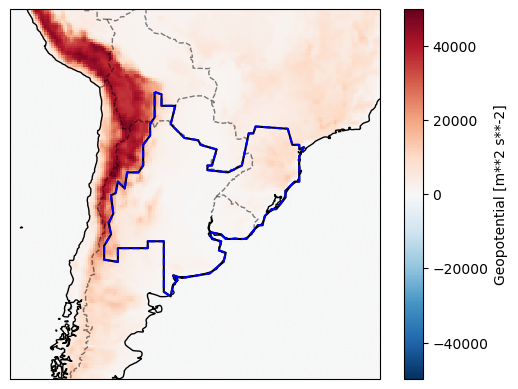

In [12]:
fig, ax = plt.subplots(ncols = 1, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)
gp.plot(ax = ax)
sf.boundary.plot(ax = ax, color = "k")
ax.plot(px.x, px.y, color = "blue", ls = "--")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5, )

## **Event maps**

Latest data downloaded Jan 17th: up to & including Jan 11th for both CPC and ERA5.

### **Drought classification**

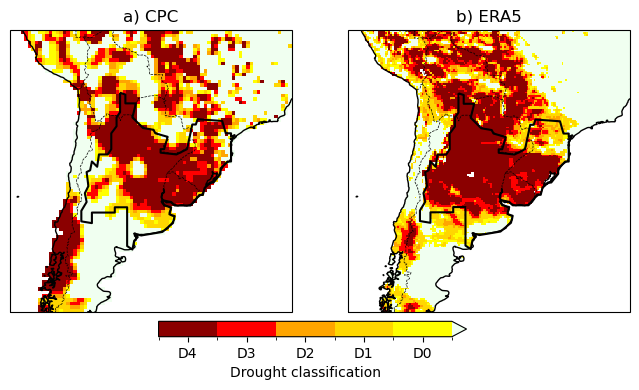

In [59]:
event_date = "2023-01"

# load latest data, discretize to get drought classifications
cpc = xr.open_dataset("data/cpc_spi3_monthly.nc").spi.sel(time = event_date)
era5 = xr.open_dataset("data/era5_spi3_monthly.nc").spi.sel(time = event_date)

cpc, era5 = [xr.apply_ufunc(np.digitize, da, kwargs={'bins': [-np.inf, -2, -1.55, -1.25, -.75, -.5]}).where(~np.isnan(da)) for da in [cpc, era5]]

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
provinces = gpd.read_file("sf/provinces").set_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow']); cmap.set_over('honeydew')
cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.07, "shrink" : 0.85, "label" : "Drought classification", "ticks" : list(range(1,6))}
plot_kwargs = {"cmap" : cmap, "norm" : matplotlib.colors.BoundaryNorm(np.arange(0.5,6.5,1), cmap.N), "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

cbar = cpc.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("a) CPC")
era5.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("b) ERA5")

for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    # ax.add_feature(cartopy.feature.RIVERS, color = "darkblue")
    # provinces.boundary.plot(ax = ax, color = "k", ls = "--", alpha = 0.5, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
    
# plt.suptitle("Drought classification in January 2023 based on 3-month SPI", fontweight = "bold")

plt.savefig("event-map_spi3_jan23.png")

### **Absolute precipitation**

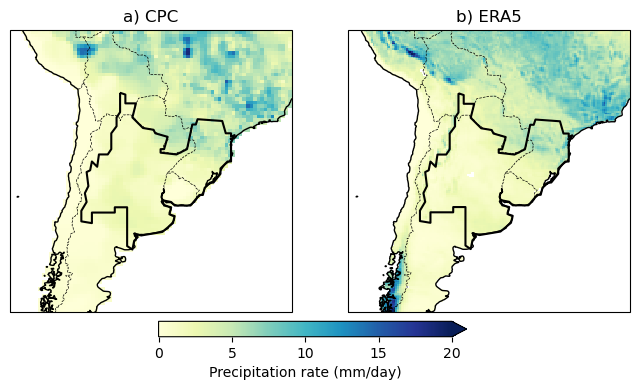

In [65]:
event_date = "2023-01"

# load latest data
cpc = xr.open_dataset("data/cpc_precip_monthly.nc").precip.rolling(time = 4).mean().sel(time = event_date)
era5 = xr.open_dataset("data/era5_precip_monthly.nc").precip.rolling(time = 4).mean().sel(time = event_date)

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
provinces = gpd.read_file("sf/provinces").set_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 20, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

cbar = cpc.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("a) CPC")
era5.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("b) ERA5")

for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    # ax.add_feature(cartopy.feature.RIVERS, color = "darkblue")
    # provinces.boundary.plot(ax = ax, color = "k", ls = "--", alpha = 0.5, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "max", label = "Precipitation rate (mm/day)")
    
# plt.suptitle("Mean precipitation rate from November 1st 2022 - January 11th 2023", fontweight = "bold")

plt.savefig("event-map_pr-ondj_jan23.png")

### **Absolute precipitation anomaly**

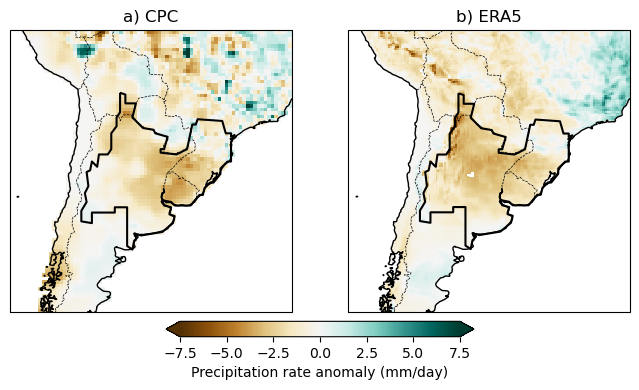

In [85]:
event_date = "2023-01"

# load latest data
cpc = xr.open_dataset("data/cpc_precip_monthly.nc").precip.rolling(time = 4).mean().groupby("time.month")[1]
era5 = xr.open_dataset("data/era5_precip_monthly.nc").precip.rolling(time = 4).mean().groupby("time.month")[1]

cpc, era5 = [(da.sel(time = "2023") - da.sel(time = slice("1980", "2022")).mean("time")) for da in [cpc, era5]]

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
provinces = gpd.read_file("sf/provinces").set_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plot_kwargs = {"cmap" : "BrBG", "vmin" : -7.5, "vmax" : 7.5, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

cbar = cpc.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("a) CPC")
era5.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("b) ERA5")

for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    # ax.add_feature(cartopy.feature.RIVERS, color = "darkblue")
    # provinces.boundary.plot(ax = ax, color = "k", ls = "--", alpha = 0.5, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "both", label = "Precipitation rate anomaly (mm/day)")
    
# plt.suptitle("Anomaly in mean precipitation rate from November 1st 2022 - January 11th 2023\n wrt climatology 1980-2010", fontweight = "bold")

plt.savefig("event-map_pr-anom-ondj_jan23.png")

## **Observational analysis (reanalysis)**

### **Daily time series of mean precip in study region**

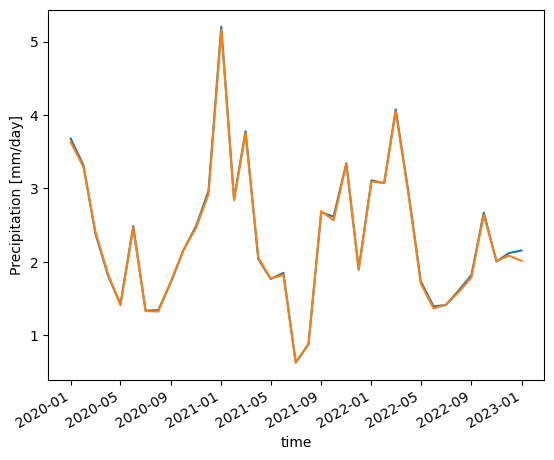

In [54]:
# quick check that ERA5 data downloaded from Climate Explorer is correctly masked
era5_m = xr.open_dataset("data/era5_precip_monthly.nc").precip
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
rm = regionmask.mask_3D_geopandas(sf, era5_m.lon, era5_m.lat).squeeze(drop = True)
era5_m = era5_m.where(rm == 1).mean(["lat", "lon"])

era5 = xr.open_dataset("data/iera5_prcp_daily_e_mask25_5lan_su.nc").tp.sel(time = slice(None, "2023-01-11")) # remove forecast days
era5.rename("precip").to_netcdf("data/era5_CSA_daily.nc")
era5.resample(time = "MS").mean().sel(time = slice("2020", None)).plot()

era5_m.sel(time = slice("2020", None)).plot()

In [3]:
# extract daily time series of mean over study region
cpc = xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).precip
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
rm = regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat).squeeze(drop = True)
cpc = cpc.where(rm).mean(["lat", "lon"])
cpc.to_netcdf("data/cpc_CSA_daily.nc")

### **Spatial patterns**

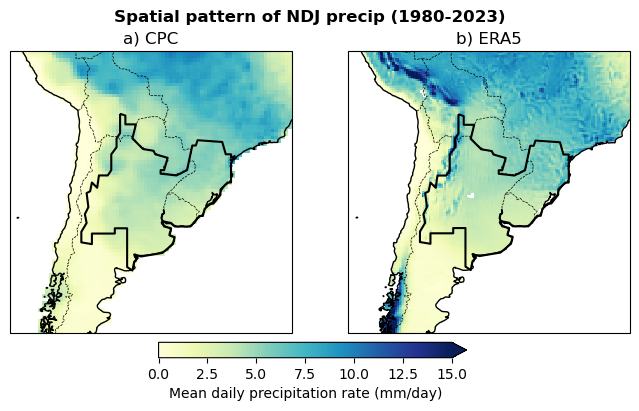

In [116]:
# spatial patterns of NDJ precip from 1980-present

cpc = xr.open_dataset("data/cpc_precip_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")[1].dropna("time", "all").sel(time = slice("1980", None)).mean("time")
era5 = xr.open_dataset("data/era5_precip_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")[1].dropna("time", "all").sel(time = slice("1980", None)).mean("time")

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 15, "add_colorbar" : False}

cbar = cpc.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("a) CPC")
era5.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("b) ERA5")

# plt.gcf().axes[-1].set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])

for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "max", label = "Mean daily precipitation rate (mm/day)")
# cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
    
plt.suptitle("Spatial pattern of NDJ precip (1980-2023)", fontweight = "bold")

plt.savefig("spatial_pr-NDJ_obs.png")

### **Seasonal cycle**

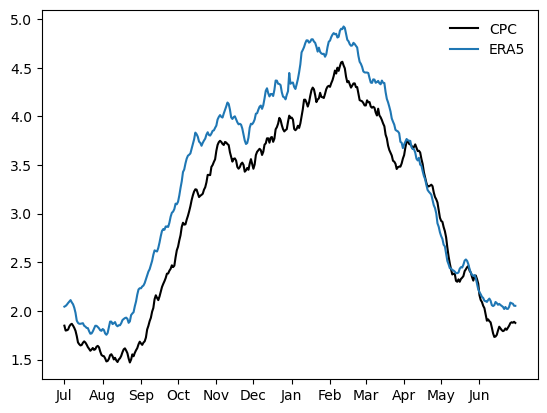

In [35]:
era5 = xr.open_dataset("data/era5_CSA_daily.nc").precip
cpc = xr.open_dataset("data/cpc_CSA_daily.nc").precip

y_offset = 365-era5.sel(time = "2020-07-01").time.dt.dayofyear

era5_sc = era5.rolling(time = 15).mean().groupby("time.dayofyear").mean()
era5_sc = era5_sc.reindex(dayofyear = era5_sc.dayofyear.sortby((era5_sc.dayofyear + y_offset) % 366))

cpc_sc = cpc.rolling(time = 15).mean().groupby("time.dayofyear").mean()
cpc_sc = cpc_sc.reindex(dayofyear = cpc_sc.dayofyear.sortby((cpc_sc.dayofyear + y_offset) % 366))

plt.plot(cpc_sc, color = "k", label = "CPC")
plt.plot(era5_sc, color = "tab:blue", label = "ERA5")

month_xlabels(era5.sel(time = slice("2019-07-01", "2020-06-30")).time, ax = plt.gcf().axes[0])
plt.legend(edgecolor = "w")

plt.axvline()

### **3-month or 4-month precip?**

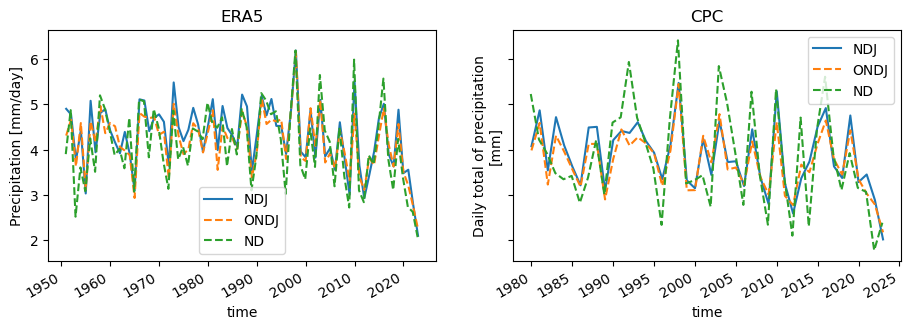

In [86]:
era5 = xr.open_dataset("data/era5_CSA_daily.nc").precip
cpc = xr.open_dataset("data/cpc_CSA_daily.nc").precip

era5_ndj = era5.resample(time = "MS").mean().rolling(time = 3).mean().groupby("time.month")[1]
cpc_ndj = cpc.resample(time = "MS").mean().rolling(time = 3).mean().groupby("time.month")[1]

era5_ondj = era5.resample(time = "MS").mean().rolling(time = 4).mean().groupby("time.month")[1]
cpc_ondj = cpc.resample(time = "MS").mean().rolling(time = 4).mean().groupby("time.month")[1]

era5_nd = era5.resample(time = "MS").mean().rolling(time = 2).mean().groupby("time.month")[12]
cpc_nd = cpc.resample(time = "MS").mean().rolling(time = 1).mean().groupby("time.month")[12]

fig, axs = plt.subplots(ncols = 2, figsize = (11,3), sharey = True)

era5_ndj.plot(ax = axs[0], label = "NDJ")
era5_ondj.plot(ax = axs[0], ls = "--", label = "ONDJ")
era5_nd.plot(ax = axs[0], ls = "--", label = "ND")
axs[0].set_title("ERA5"); axs[0].legend()

cpc_ndj.plot(ax = axs[1], label = "NDJ")
cpc_ondj.plot(ax = axs[1], label = "ONDJ", ls = "--")
cpc_nd.plot(ax = axs[1], ls = "--", label = "ND")
axs[1].set_title("CPC"); axs[1].legend()

### **Time series for climate explorer**

In [95]:
era5_ndj.assign_coords(time = era5_ndj.time.dt.year).dropna("time", "any").to_pandas()

for ens in ["cpc", "era5"]:
        
    csv_fnm = "ts/CSA-drought_pr-ndj_"+ens+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: "+ens+" NDJ precip central South America drought (up to Jan 11) 2023, c.barnes22@imperial.ac.uk"
    str2 = "# precip [mm/day] NDJ mean precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year precip"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    da = xr.open_dataset("data/"+ens+"_CSA_daily.nc").precip
    da_ndj = da.resample(time = "MS").mean().rolling(time = 3).mean().groupby("time.month")[1].dropna("time", "any")
    da_ndj = da_ndj.assign_coords(time = da_ndj.time.dt.year)

    da_ndj.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

## **Station data**

In [183]:
# load station data
df = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'), 
                   [pd.read_csv(fnm, sep = "\t", index_col = "fecha")[["prcp"]].rename(columns = {"prcp" : fnm[9:14]}) for fnm in glob.glob("stations/*.txt")])
df.index = pd.to_datetime(df.index)

# filter out points outside the study region
df = df.loc[:,[int(c) in stn_gdf.index for c in df.columns]]

In [194]:
# filter out points with missing data Oct-Dec
df = df.loc[:,df.loc[slice("2022-10", "2022-12-25")].count(axis = 0) >= 86]

In [192]:
# load station locations; filter stations to include only those inside the study region
stn = pd.read_csv("stations/metadatos.csv", index_col = "omm_id")

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
stn_gdf = gpd.GeoDataFrame(stn, geometry= gpd.points_from_xy(stn.longitud, stn.latitud), crs = cartopy.crs.PlateCarree())
stn_gdf = gpd.sjoin(stn_gdf, sf, predicate='within')

In [241]:
# list of stations with data for all of OND
stn_gdf_22 = stn_gdf.loc[[int(c) for c in df.columns]]

# put the Bolivian stations back in
stn_gdf_bol = stn_gdf.loc[stn_gdf.geometry.y > -22]

# and also the Brazilian stations
stn_gdf_bra = stn_gdf.loc[stn_gdf.geometry.x > -55]

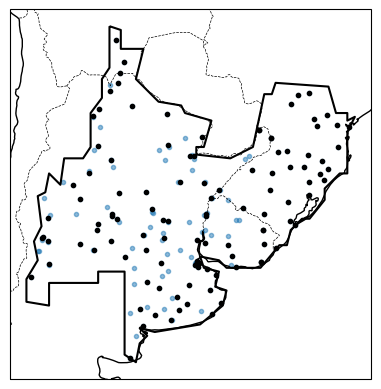

In [242]:
fig, ax = plt.subplots(ncols = 1, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)
ax.scatter(stn_gdf.longitud, stn_gdf.latitud, marker = ".", alpha = 0.5)
ax.scatter(stn_gdf_22.longitud, stn_gdf_22.latitud, marker = ".", color = "k")
ax.scatter(stn_gdf_bol.longitud, stn_gdf_bol.latitud, marker = ".", color = "k")
ax.scatter(stn_gdf_bra.longitud, stn_gdf_bra.latitud, marker = ".", color = "k")

sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)

In [234]:
stn_gdf_bra

,nombre,latitud,longitud,elevacion,nivel_adm1,geometry,index_right,FID
omm_id,,,,,,,,
87118,Famaillá INTA,-27.0500,-65.4200,363.00,Tucumán,POINT (-65.420 -27.050),0,0
83766,Londrina,-23.3256,-51.1417,566.46,Paraná,POINT (-51.142 -23.326),0,0
83767,Maringá,-23.4000,-51.9167,542.00,Paraná,POINT (-51.917 -23.400),0,0
83783,Campo Mourão,-24.0500,-52.3700,616.40,Paraná,POINT (-52.370 -24.050),0,0
83811,Ivaí,-25.0108,-50.8536,808.00,Paraná,POINT (-50.854 -25.011),0,0
...,...,...,...,...,...,...,...,...
9987015,Canals INTA,-33.5700,-62.8800,125.00,Córdoba,POINT (-62.880 -33.570),0,0
90000001,Las Brujas,-34.6719,-56.3400,32.00,Canelones,POINT (-56.340 -34.672),0,0
90000003,Tacuarembó,-31.7089,-55.8267,115.00,Tacuarembó,POINT (-55.827 -31.709),0,0


<AxesSubplot: >

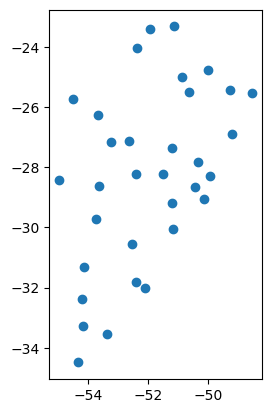

In [229]:
stn_gdf.loc[stn_gdf.geometry.x > -55].plot()